In [8]:
pip install -r requirements.txt

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.5 MB 6.7 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/9.5 MB 7.5 MB/s eta 0:00:01
   --------------- ------------------------ 3.7/9.5 MB 6.6 MB/s eta 0:00:01
   -------------------- ------------------- 5.0/9.5 MB 6.4 MB/s eta 0:00:01
   ---------------------------- ----------- 6.8/9.5 MB 6.8 MB/s eta 0:00:01
   ------------------------------------ --- 8.7/9.5 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

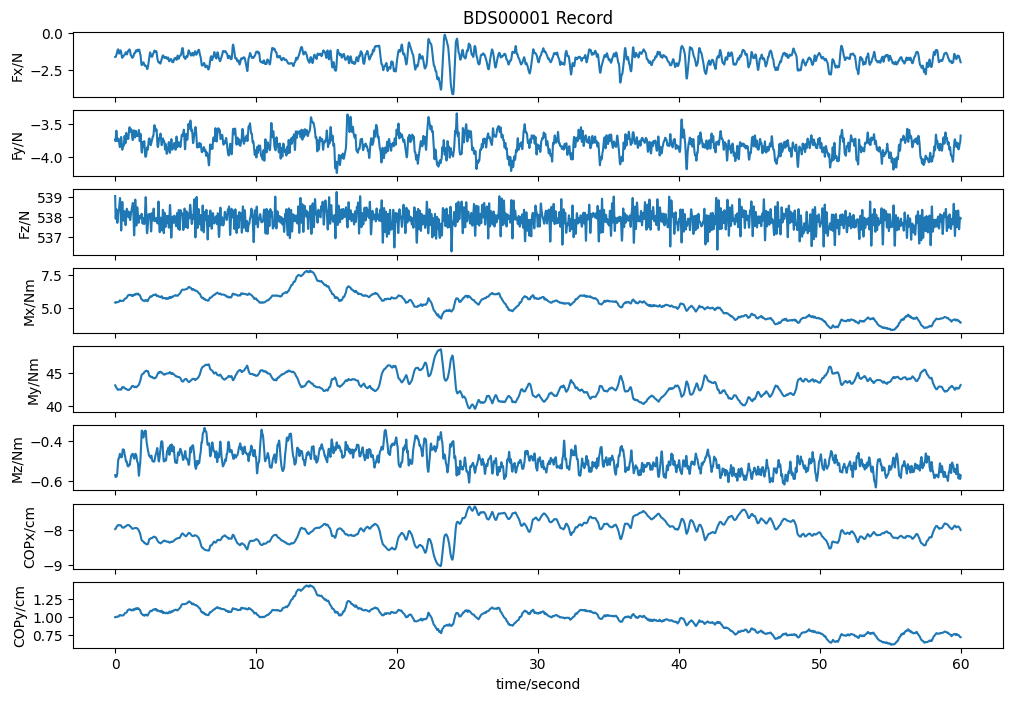

['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'COPx', 'COPy']


In [3]:
#Data 1 WOMAN
#BDS00001-3 and 7-9 Eye Open
#BDS00004-6 and 10-12 Eye Closed

#Read data
record1 = wfdb.rdrecord('data/BDS00001')

#Plot data
wfdb.plot_wfdb(record=record1, title='BDS00001 Record', time_units='seconds', figsize=(12, 8))
plt.show()

print(record1.sig_name)



Sampling frequency: 100 Hz


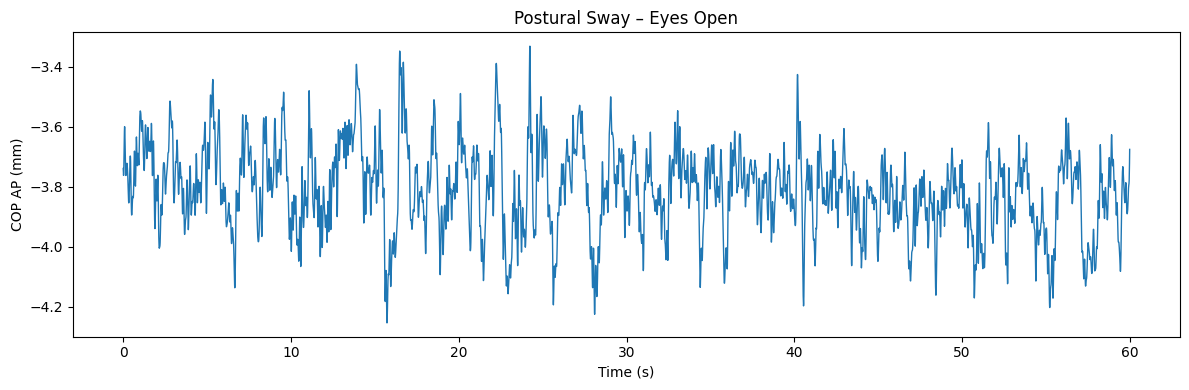

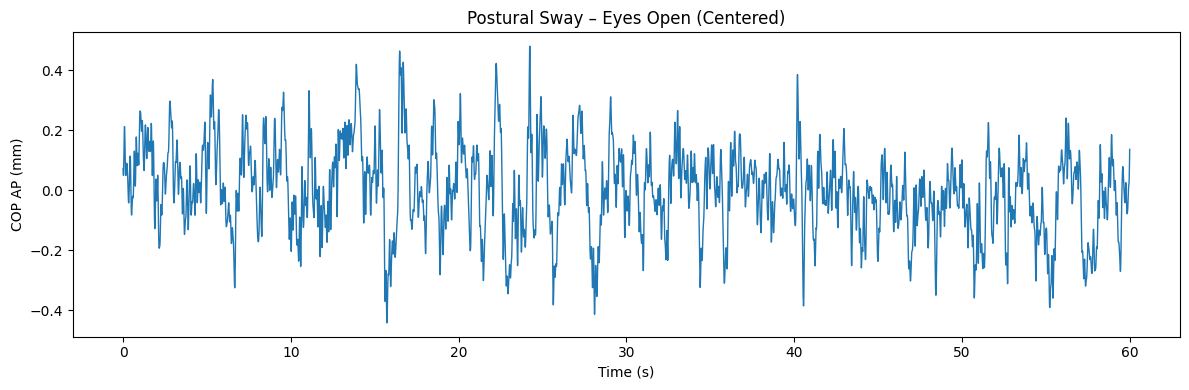

In [4]:
fs = record1.fs
print (f"Sampling frequency: {fs} Hz")

cop_y = record1.p_signal[:, 1]  # COP_Y
time = np.arange(len(cop_y)) / fs

plt.figure(figsize=(12,4))
plt.plot(time, cop_y, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("COP AP (mm)")
plt.title("Postural Sway – Eyes Open")
plt.tight_layout()
plt.show()

cop_y = cop_y - np.mean(cop_y)  # Center the signal

plt.figure(figsize=(12,4))
plt.plot(time, cop_y, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("COP AP (mm)")
plt.title("Postural Sway – Eyes Open (Centered)")
plt.tight_layout()
plt.show()

## 1. Stochastic Process Analysis (Session 1)

<Figure size 1000x800 with 0 Axes>

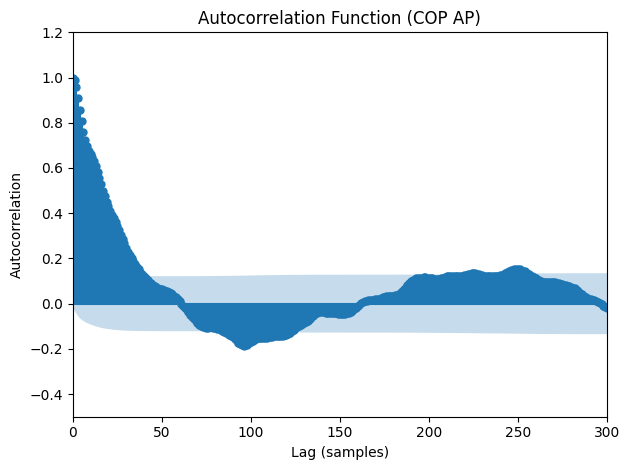

In [15]:
#Compute and plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10,8))
plot_acf(cop_y, lags=300)
plt.title("Autocorrelation Function (COP AP)")
plt.xlabel("Lag (samples)")
plt.ylabel("Autocorrelation")
plt.xlim(0, 300)
plt.ylim(-0.5, 1.2)
plt.tight_layout()
plt.show()


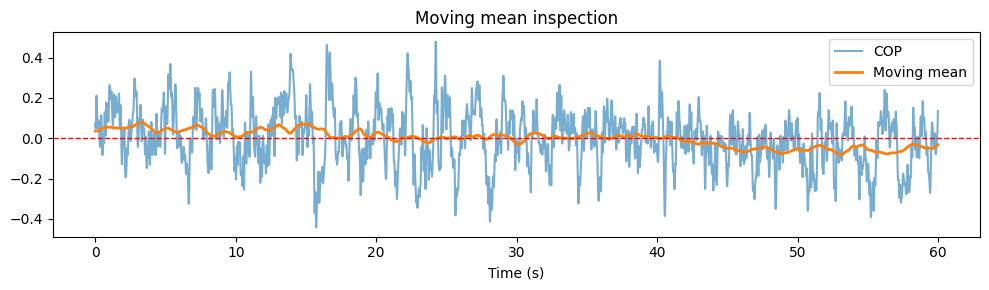

Statistical test for stationarity (ADF Test):
ADF statistic: -8.995877588282548
p-value: 6.697181961555256e-15
Critical values: {'1%': np.float64(-3.431445280853765), '5%': np.float64(-2.862024013055219), '10%': np.float64(-2.5670276377503667)}


In [22]:
#Test for stationarity (visual inspection and statistical test)
#Visual inspection and ADF test for stationarity    

window = int(5 * fs)  # 5 secondes
moving_mean = np.convolve(cop_y, np.ones(window)/window, mode='same')

plt.figure(figsize=(10,3))
plt.plot(time, cop_y, alpha=0.6, label="COP")
plt.plot(time, moving_mean, linewidth=2, label="Moving mean")
plt.legend()
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Time (s)")
plt.title("Moving mean inspection")
plt.tight_layout()
plt.show()


#Statistical test
adf_stat, p_value, _, _, critical_values, _ = adfuller(cop_y)
print("Statistical test for stationarity (ADF Test):")
print("ADF statistic:", adf_stat)
print("p-value:", p_value)
print("Critical values:", critical_values)

The Augmented Dickey-Fuller test strongly rejected the null hypothesis of non-stationarity (ADF = –8.99, p < 0.001). Visual inspection confirmed stable mean and variance over time, indicating that the COP_AP signal can be considered stationary over the analyzed interval.

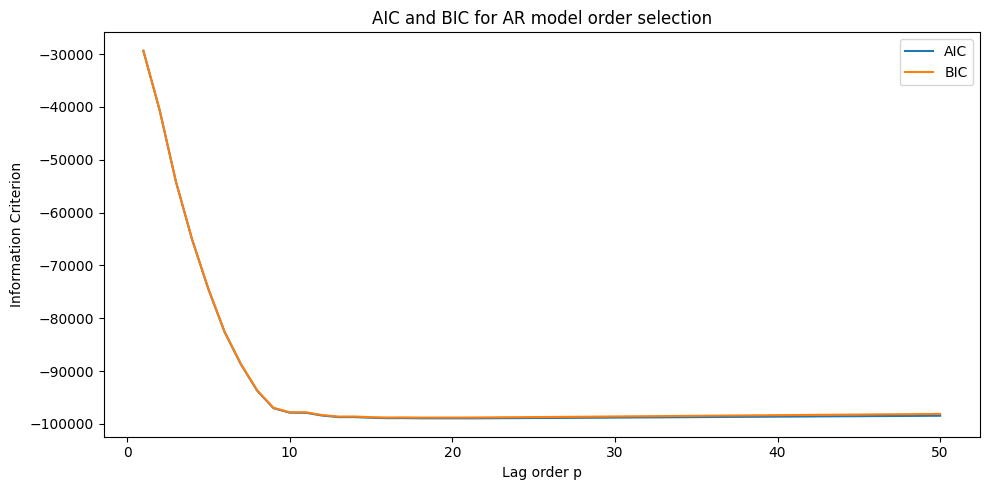

Optimal lag order according to AIC: 21
Optimal lag order according to BIC: 18


In [25]:
#Fit an Ar(p) model
#Determine optimal order p using AIC/BIC

aic_values = []
bic_values = []
max_lag = 50
for lag in range(1, max_lag + 1):
    model = AutoReg(cop_y, lags=lag, old_names=False).fit()
    aic_values.append(model.aic)
    bic_values.append(model.bic)
plt.figure(figsize=(10,5))
plt.plot(range(1, max_lag + 1), aic_values, label='AIC')
plt.plot(range(1, max_lag + 1), bic_values, label='BIC')
plt.xlabel('Lag order p')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for AR model order selection')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Optimal lag order according to AIC: {np.argmin(aic_values) + 1}")
print(f"Optimal lag order according to BIC: {np.argmin(bic_values) + 1}")


AR(18) model summary:
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 6000
Model:                    AutoReg(18)   Log Likelihood               49487.110
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Mon, 19 Jan 2026   AIC                         -98934.221
Time:                        16:24:24   BIC                         -98800.290
Sample:                            18   HQIC                        -98887.704
                                 6000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.568e-08   7.99e-07      0.032      0.974   -1.54e-06    1.59e-06
y.L1           7.3179      0.013    568.980      0.000       7.293       7.343
y.L2         -25.0781      0.0

<Figure size 800x300 with 0 Axes>

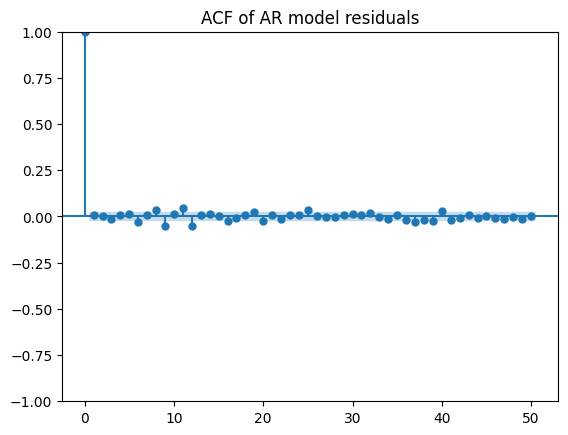

In [30]:
#Report model parameters and goodness of fit

optimal_lag = np.argmin(bic_values) + 1  # Choose lag based on BIC
model = AutoReg(cop_y, lags=optimal_lag, old_names=False).fit()
print(f"AR({optimal_lag}) model summary:")
print(model.summary())

residuals = model.resid

plt.figure(figsize=(8,3))
plot_acf(residuals, lags=50)
plt.title("ACF of AR model residuals")
plt.show()

In [36]:
#Compare with MA and ARMA models if appropriate

#MA
model_ma = ARIMA(cop_y, order=(0,0,5)).fit()

#ARMA
model_arma = ARIMA(cop_y, order=(5,0,5)).fit()


c:\Users\theol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\theol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
#Create a table comparing model AIC and BIC values
model_comparison = pd.DataFrame({
    'Model': ['AR', 'MA', 'ARMA'],
    'AIC': [model.aic, model_ma.aic, model_arma.aic],
    'BIC': [model.bic, model_ma.bic, model_arma.bic],
    'Log-Likelihood': [model.llf, model_ma.llf, model_arma.llf]
})
print(model_comparison)

  Model           AIC           BIC  Log-Likelihood
0    AR -98934.220614 -98800.290409    49487.110307
1    MA -47026.288304 -46979.391701    23520.144152
2  ARMA -69071.312106 -68990.917929    34547.656053


The AR(18) model was selected because it best captures the short-term temporal dependencies of the COP_y signal, as evidenced by the lowest AIC and BIC values compared to MA(5) and ARMA(5,5). Residuals showed no significant autocorrelation, indicating that the model adequately represents the dynamics of postural control while remaining interpretable.